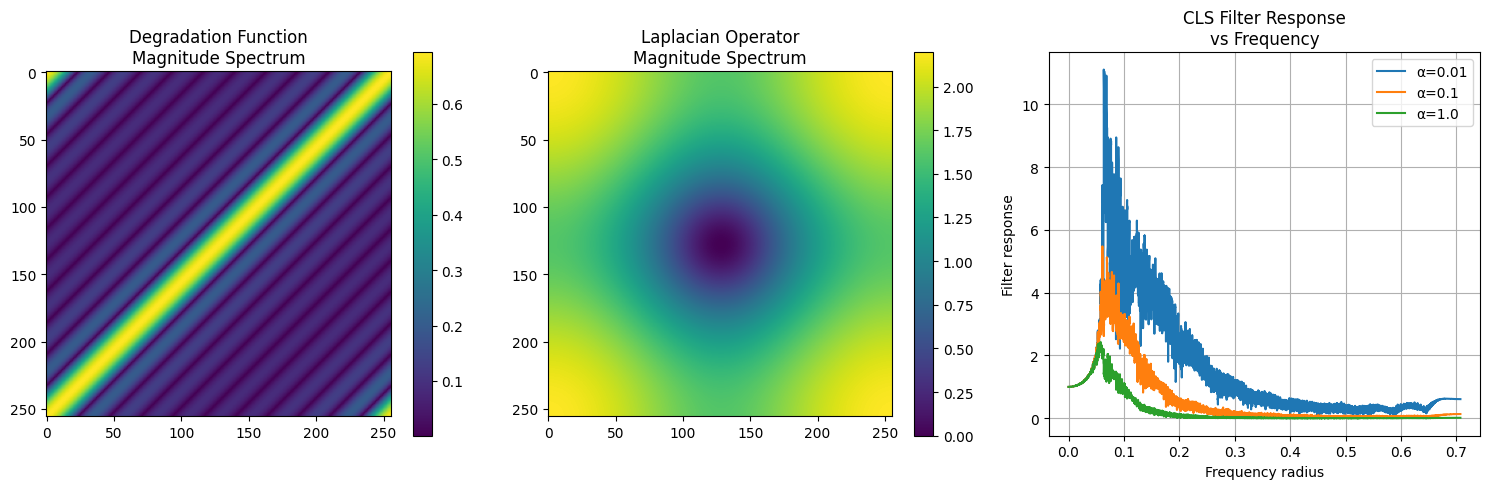

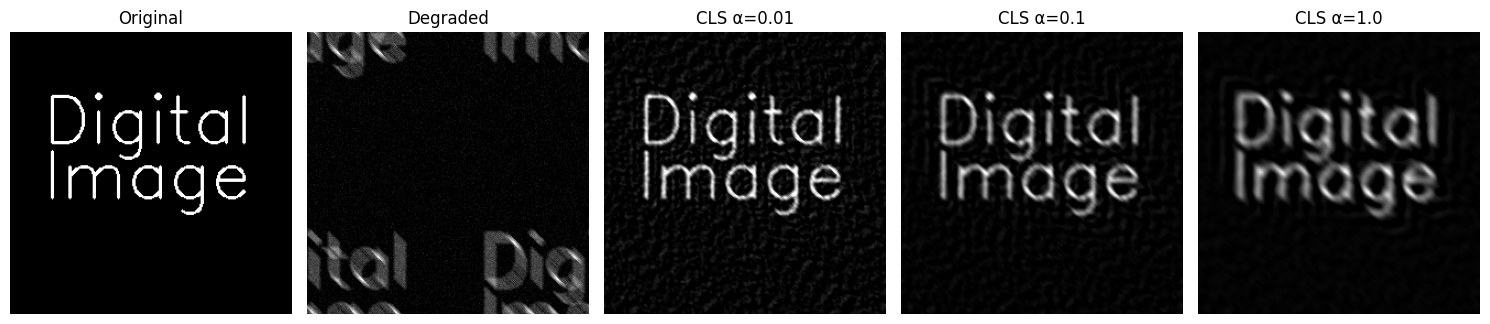

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def create_frequency_grid(M, N):
    """Create frequency grid for MxN image."""
    u = np.fft.fftfreq(M)
    v = np.fft.fftfreq(N)
    u, v = np.meshgrid(u, v)
    r = np.sqrt(u**2 + v**2)
    return u, v, r

def create_motion_psf(image_size, motion_angle=45, motion_dist=15):
    """Create Point Spread Function for motion blur."""
    psf = np.zeros(image_size)
    center = (image_size[0]//2, image_size[1]//2)

    angle_rad = np.deg2rad(motion_angle)
    dx = motion_dist * np.cos(angle_rad)
    dy = motion_dist * np.sin(angle_rad)

    x1, y1 = center[1] - dx//2, center[0] - dy//2
    x2, y2 = center[1] + dx//2, center[0] + dy//2

    cv2.line(psf, (int(x1), int(y1)), (int(x2), int(y2)), 1, 1)
    return psf / psf.sum()

def create_laplacian_operator():
    """Create Laplacian operator in spatial domain."""
    return np.array([[0, -1, 0],
                    [-1, 4, -1],
                    [0, -1, 0]])

def analyze_cls_filter(image_size=(256, 256), alpha_values=[0.01, 0.1, 1.0]):
    """Analyze CLS filter characteristics."""
    # Create grids
    u, v, r = create_frequency_grid(image_size[0], image_size[1])

    # Create degradation function (motion blur)
    psf = create_motion_psf(image_size)
    H = np.fft.fft2(psf)

    # Create Laplacian operator
    P = np.fft.fft2(create_laplacian_operator(), s=image_size)

    # Plot filter responses
    plt.figure(figsize=(15, 5))

    # 1. Plot degradation function magnitude
    plt.subplot(131)
    H_mag = np.abs(np.fft.fftshift(H))
    plt.imshow(np.log1p(H_mag), cmap='viridis')
    plt.title('Degradation Function\nMagnitude Spectrum')
    plt.colorbar()

    # 2. Plot Laplacian magnitude
    plt.subplot(132)
    P_mag = np.abs(np.fft.fftshift(P))
    plt.imshow(np.log1p(P_mag), cmap='viridis')
    plt.title('Laplacian Operator\nMagnitude Spectrum')
    plt.colorbar()

    # 3. Plot 1D frequency responses
    plt.subplot(133)
    r_flat = r.flatten()
    sort_idx = np.argsort(r_flat)

    for alpha in alpha_values:
        H_mag_squared = np.abs(H)**2
        P_mag_squared = np.abs(P)**2

        # Calculate filter response
        response = np.abs(H) / (H_mag_squared + alpha * P_mag_squared)
        response_flat = response.flatten()[sort_idx]
        r_sorted = r_flat[sort_idx]

        # Plot smoothed response
        from scipy.signal import savgol_filter
        window = 51  # must be odd
        if len(r_sorted) > window:
            smoothed = savgol_filter(response_flat, window, 3)
            plt.plot(r_sorted, smoothed, label=f'α={alpha}')

    plt.xlabel('Frequency radius')
    plt.ylabel('Filter response')
    plt.title('CLS Filter Response\nvs Frequency')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def demonstrate_restoration(image_size=(256, 256)):
    """Demonstrate CLS restoration with different parameters."""
    # Create test image
    image = np.zeros(image_size, dtype=np.uint8)
    cv2.putText(image, 'Digital', (30, 100), cv2.FONT_HERSHEY_SIMPLEX, 2, 255, 2)
    cv2.putText(image, 'Image', (30, 150), cv2.FONT_HERSHEY_SIMPLEX, 2, 255, 2)

    # Create PSF and degrade image
    psf = create_motion_psf(image_size)

    # Add noise
    noise_std = 10
    G = np.fft.fft2(image)
    H = np.fft.fft2(psf, s=image_size)
    blurred = np.real(np.fft.ifft2(G * H))
    degraded = blurred + np.random.normal(0, noise_std, image_size)
    degraded = np.clip(degraded, 0, 255).astype(np.uint8)

    # Restore with different alpha values
    alpha_values = [0.01, 0.1, 1.0]
    restored_images = []

    for alpha in alpha_values:
        P = np.fft.fft2(create_laplacian_operator(), s=image_size)
        H_conj = np.conjugate(H)
        H_mag_squared = np.abs(H)**2
        P_mag_squared = np.abs(P)**2

        # CLS filter
        F = np.fft.fft2(degraded)
        numerator = H_conj
        denominator = H_mag_squared + alpha * P_mag_squared
        restored_f = numerator / (denominator + 1e-10) * F
        restored = np.real(np.fft.ifft2(restored_f))
        restored = np.clip(restored, 0, 255).astype(np.uint8)
        restored_images.append(restored)

    # Visualize results
    plt.figure(figsize=(15, 10))

    plt.subplot(251)
    plt.imshow(image, cmap='gray')
    plt.title('Original')
    plt.axis('off')

    plt.subplot(252)
    plt.imshow(degraded, cmap='gray')
    plt.title('Degraded')
    plt.axis('off')

    for i, (restored, alpha) in enumerate(zip(restored_images, alpha_values)):
        plt.subplot(253 + i)
        plt.imshow(restored, cmap='gray')
        plt.title(f'CLS α={alpha}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

def main():
    # Analyze filter characteristics
    analyze_cls_filter()

    # Demonstrate restoration
    demonstrate_restoration()

if __name__ == "__main__":
    main()